In [1]:
import os
import pdb
import h5py
import pickle
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm

# Config

In [2]:
geuvadis_eQTL_dir = "/clusterfs/nilah/Geuvadis/E-GEUV-1/analysis_results"
geuvadis_genotypes_dir = "/clusterfs/nilah/Geuvadis/E-GEUV-1/genotypes/"
data_dir = "/clusterfs/nilah/ruchir/src/finetuning-enformer/finetuning/data/h5_bins_384_chrom_split/"
root_save_dir = "/global/scratch/users/aniketh/finetune-enformer/"
code_dir = "/global/home/users/aniketh/finetuning-enformer/"
fasta_path = "/clusterfs/nilah/aniketh/hg19/hg19.fa"

models_dir = os.path.join(root_save_dir, "saved_models")
test_preds_dir = os.path.join(root_save_dir, "test_preds_final")
ISM_preds_dir = os.path.join(root_save_dir, "ISM")

train_h5_path = os.path.join(data_dir, "train.h5")
val_h5_path = os.path.join(data_dir, "val.h5")
test_h5_path = os.path.join(data_dir, "test.h5")

GEUVADIS_COUNTS_PATH = "../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
GENE_CLASS_PATH = os.path.join(
    code_dir, "finetuning", "data", "h5_bins_384_chrom_split", "gene_class.csv"
)
BASELINE_PREDS_PATH = "../baseline/baseline_enformer.384_bins.rc.csv"
PREDIXCAN_PREDS_PATH = (
    "../predixcan_lite/h5_bins_384_chrom_split/384_bins_no_cv/preds.csv"
)
PREDIXCAN_COEFS_PATH = (
    "../predixcan_lite/h5_bins_384_chrom_split/384_bins_no_cv/coefs.csv"
)

all_main_run_names = {
    # "classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_parallel_h5_dataset_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --data_seed {data_seed} --resume_from_checkpoint",
    "regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    # "single_regression_counts": "NCCL_P2P_DISABLE=1 python finetuning/train_single_counts_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    #     "single_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_single_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint", ###DOEST PERFORM WELL, NOT USED
    # "joint_classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    # "joint_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "baseline": "",
}
all_seeds = [42, 97, 7]
train_h5 = h5py.File(train_h5_path, "r")
context_size = train_h5["seqs"][0].shape[1]
train_h5.close()

In [3]:
ALL_PREDS_PATHS = {}

# MAIN TEST RUNS
for run in all_main_run_names:
    if run != "baseline":
        for i, seed in enumerate(all_seeds):
            train_cmd_template = all_main_run_names[run]
            lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(" ")[
                0
            ]
            wd_used_during_training = train_cmd_template.split("--weight_decay ")[
                -1
            ].split(" ")[0]
            rcprob_used_during_training = 0.5
            rsmax_used_during_training = 3

            model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}"
            ALL_PREDS_PATHS[model_name] = os.path.join(ISM_preds_dir, model_name)
    else:
        ALL_PREDS_PATHS[run] = os.path.join(ISM_preds_dir, run)

test_h5 = h5py.File(test_h5_path, "r")

# Read and collect ISM scores for every eQTL

In [4]:
# read base files required for gene info

gene_class_df = pd.read_csv(GENE_CLASS_PATH)
population_split_genes = gene_class_df[
    gene_class_df["class"] == "yri_split"
].reset_index(drop=True)
print(f"Number of population-split genes: {len(population_split_genes)}")

# get all eQTLs within the context
if not os.path.exists(
    os.path.join(data_dir, "YRI_eQTLs_within_context_for_selected_genes.csv")
):
    geuvadis_id_to_dbSNP_id = pd.read_csv(
        os.path.join(
            geuvadis_genotypes_dir, "Phase1.Geuvadis_dbSnp137_idconvert.txt.gz"
        ),
        names=["dbSNP_id", "geuvadis_id"],
        sep="\t",
    )
    geuvadis_id_annotations = pd.read_csv(
        os.path.join(
            geuvadis_genotypes_dir,
            "ALL.phase1_release_v3.20101123.snps_indels_sv.sites.gdid.gdannot.v2.vcf.gz",
        ),
        skiprows=78,
        sep="\t",
    )
    geuvadis_id_annotations = geuvadis_id_annotations.merge(
        geuvadis_id_to_dbSNP_id, left_on="ID", right_on="geuvadis_id", how="inner"
    )

    EUR_all_eQTLs_path = os.path.join(
        geuvadis_eQTL_dir, "EUR373.gene.cis.FDR5.all.rs137.txt.gz"
    )
    YRI_all_eQTLs_path = os.path.join(
        geuvadis_eQTL_dir, "YRI89.gene.cis.FDR5.all.rs137.txt.gz"
    )

    EUR_all_eQTLs = pd.read_csv(EUR_all_eQTLs_path, sep="\t")
    EUR_all_eQTLs = EUR_all_eQTLs[
        EUR_all_eQTLs["distance"] < (context_size // 2)
    ].reset_index(drop=True)
    EUR_all_eQTLs["abs_rvalue"] = np.abs(EUR_all_eQTLs["rvalue"])
    EUR_all_eQTLs["stable_id"] = EUR_all_eQTLs.apply(
        lambda x: x["GENE_ID"].split(".")[0], axis=1
    )
    EUR_all_eQTLs = EUR_all_eQTLs.sort_values(
        by=["GENE_ID", "abs_rvalue"], ascending=[True, False]
    ).reset_index(drop=True)

    YRI_all_eQTLs = pd.read_csv(YRI_all_eQTLs_path, sep="\t")
    YRI_all_eQTLs = YRI_all_eQTLs[
        YRI_all_eQTLs["distance"] < (context_size // 2)
    ].reset_index(drop=True)
    YRI_all_eQTLs["abs_rvalue"] = np.abs(YRI_all_eQTLs["rvalue"])
    YRI_all_eQTLs["stable_id"] = YRI_all_eQTLs.apply(
        lambda x: x["GENE_ID"].split(".")[0], axis=1
    )
    YRI_all_eQTLs = YRI_all_eQTLs.sort_values(
        by=["GENE_ID", "abs_rvalue"], ascending=[True, False]
    ).reset_index(drop=True)

    EUR_all_eQTLs = EUR_all_eQTLs.merge(
        geuvadis_id_annotations[
            ["dbSNP_id", "geuvadis_id", "#CHROM", "POS", "REF", "ALT", "INFO"]
        ],
        left_on="SNP_ID",
        right_on="dbSNP_id",
        how="inner",
    )
    YRI_all_eQTLs = YRI_all_eQTLs.merge(
        geuvadis_id_annotations[
            ["dbSNP_id", "geuvadis_id", "#CHROM", "POS", "REF", "ALT", "INFO"]
        ],
        left_on="SNP_ID",
        right_on="dbSNP_id",
        how="inner",
    )

    GEUVADIS_COUNTS = pd.read_csv(GEUVADIS_COUNTS_PATH)
    EUR_all_eQTLs = EUR_all_eQTLs.merge(
        GEUVADIS_COUNTS[["stable_id", "our_gene_name"]], on="stable_id", how="inner"
    )
    YRI_all_eQTLs = YRI_all_eQTLs.merge(
        GEUVADIS_COUNTS[["stable_id", "our_gene_name"]], on="stable_id", how="inner"
    )

    EUR_eQTLs_within_context_for_selected_genes = gene_perf.merge(
        EUR_all_eQTLs, left_on="gene", right_on="our_gene_name", how="inner"
    )
    EUR_eQTLs_within_context_for_selected_genes = (
        EUR_eQTLs_within_context_for_selected_genes[
            EUR_eQTLs_within_context_for_selected_genes.columns[8:]
        ]
    )
    EUR_eQTLs_within_context_for_selected_genes.to_csv(
        os.path.join(data_dir, "EUR_eQTLs_within_context_for_selected_genes.csv"),
        index=False,
    )

    YRI_eQTLs_within_context_for_selected_genes = gene_perf.merge(
        YRI_all_eQTLs, left_on="gene", right_on="our_gene_name", how="inner"
    )
    YRI_eQTLs_within_context_for_selected_genes = (
        YRI_eQTLs_within_context_for_selected_genes[
            YRI_eQTLs_within_context_for_selected_genes.columns[8:]
        ]
    )
    YRI_eQTLs_within_context_for_selected_genes.to_csv(
        os.path.join(data_dir, "YRI_eQTLs_within_context_for_selected_genes.csv"),
        index=False,
    )

EUR_eQTLs_within_context_for_selected_genes = pd.read_csv(
    os.path.join(data_dir, "EUR_eQTLs_within_context_for_selected_genes.csv")
)
YRI_eQTLs_within_context_for_selected_genes = pd.read_csv(
    os.path.join(data_dir, "YRI_eQTLs_within_context_for_selected_genes.csv")
)

EUR_eQTLs_within_context_for_selected_genes = (
    EUR_eQTLs_within_context_for_selected_genes.merge(
        population_split_genes[["gene"]],
        left_on="our_gene_name",
        right_on="gene",
        how="inner",
    )
)
EUR_eQTLs_within_context_for_selected_genes[
    "not_SNV"
] = EUR_eQTLs_within_context_for_selected_genes.apply(
    lambda x: (len(x["REF"]) > 1) or (len(x["ALT"]) > 1), axis=1
)
EUR_eQTLs_within_context_for_selected_genes = (
    EUR_eQTLs_within_context_for_selected_genes[
        ~EUR_eQTLs_within_context_for_selected_genes["not_SNV"]
    ].reset_index(drop=True)
)
print(
    f"Num EUR SNV eQTLs for population split genes = {EUR_eQTLs_within_context_for_selected_genes.shape[0]} from {len(EUR_eQTLs_within_context_for_selected_genes['gene'].unique())} distinct genes"
)

YRI_eQTLs_within_context_for_selected_genes = (
    YRI_eQTLs_within_context_for_selected_genes.merge(
        population_split_genes[["gene"]],
        left_on="our_gene_name",
        right_on="gene",
        how="inner",
    )
)
YRI_eQTLs_within_context_for_selected_genes[
    "not_SNV"
] = YRI_eQTLs_within_context_for_selected_genes.apply(
    lambda x: (len(x["REF"]) > 1) or (len(x["ALT"]) > 1), axis=1
)
YRI_eQTLs_within_context_for_selected_genes = (
    YRI_eQTLs_within_context_for_selected_genes[
        ~YRI_eQTLs_within_context_for_selected_genes["not_SNV"]
    ].reset_index(drop=True)
)
print(
    f"Num YRI SNV eQTLs for population split genes = {YRI_eQTLs_within_context_for_selected_genes.shape[0]} from {len(YRI_eQTLs_within_context_for_selected_genes['gene'].unique())} distinct genes"
)

Number of population-split genes: 200
Num EUR SNV eQTLs for population split genes = 4800 from 145 distinct genes
Num YRI SNV eQTLs for population split genes = 256 from 14 distinct genes


In [5]:
# read ISM scores for every gene
all_ism_scores = {}
all_baseline_enformer_ism_scores = {}
all_is_ref = {}

for gene in tqdm(population_split_genes["gene"].unique()):
    all_ism_scores[gene] = np.zeros((context_size, 4))

    n_models_with_ism_scores = 0
    for model in ALL_PREDS_PATHS:
        if model == "baseline":
            continue
        if not os.path.exists(
            os.path.join(ALL_PREDS_PATHS[model], gene, "ism_scores.npz")
        ):
            print(
                f"{model}: ISM scores for {gene} have not been computed yet, skipping..."
            )
            continue

        ism_scores = np.load(
            os.path.join(ALL_PREDS_PATHS[model], gene, "ism_scores.npz")
        )
        all_ism_scores[gene] += ism_scores["ism_scores"][0]
        if gene not in all_is_ref:
            all_is_ref[gene] = ism_scores["is_refs"][0]
        n_models_with_ism_scores += 1

    if n_models_with_ism_scores == 0:
        all_ism_scores.pop(gene)
    else:
        all_ism_scores[gene] /= n_models_with_ism_scores

for gene in tqdm(population_split_genes["gene"].unique()):
    model = "baseline"
    if not os.path.exists(os.path.join(ALL_PREDS_PATHS[model], gene, "ism_scores.npz")):
        print(f"{model}: ISM scores for {gene} have not been computed yet, skipping...")
        continue

    ism_scores = np.load(os.path.join(ALL_PREDS_PATHS[model], gene, "ism_scores.npz"))
    all_baseline_enformer_ism_scores[gene] = ism_scores["ism_scores"][0]

100%|██████████| 200/200 [00:10<00:00, 18.95it/s]


## For fine-tuned Enformer

In [6]:
base_to_ind = {"A": 0, "C": 1, "G": 2, "T": 3}

# for YRI eQTLs
all_ism_scores_for_eQTLs = []
all_abs_ism_scores_for_eQTLs = []

for i in tqdm(range(len(YRI_eQTLs_within_context_for_selected_genes))):
    row = YRI_eQTLs_within_context_for_selected_genes.iloc[i]
    gene = row["our_gene_name"]
    TSS = row["TSSpos"]
    pos = row["POS"]
    assert ((pos - TSS) + (context_size // 2)) >= 0
    ref = row["REF"]
    alt = row["ALT"]

    ism_scores_at_pos = all_ism_scores[gene][((pos - TSS) + (context_size // 2))]

    assert ism_scores_at_pos[base_to_ind[ref]] == 0

    ism_score_for_eQTL = ism_scores_at_pos[base_to_ind[alt]]
    all_ism_scores_for_eQTLs.append(ism_score_for_eQTL)

    abs_ism_score_for_eQTL = np.abs(ism_scores_at_pos[base_to_ind[alt]])
    all_abs_ism_scores_for_eQTLs.append(abs_ism_score_for_eQTL)

YRI_eQTLs_within_context_for_selected_genes[
    "ism_scores_for_eQTLs"
] = all_ism_scores_for_eQTLs
YRI_eQTLs_within_context_for_selected_genes[
    "abs_ism_scores_for_eQTLs"
] = all_abs_ism_scores_for_eQTLs

# for EUR eQTLs
all_ism_scores_for_eQTLs = []
all_abs_ism_scores_for_eQTLs = []

for i in tqdm(range(len(EUR_eQTLs_within_context_for_selected_genes))):
    row = EUR_eQTLs_within_context_for_selected_genes.iloc[i]
    gene = row["our_gene_name"]
    TSS = row["TSSpos"]
    pos = row["POS"]
    assert ((pos - TSS) + (context_size // 2)) >= 0
    ref = row["REF"]
    alt = row["ALT"]

    ism_scores_at_pos = all_ism_scores[gene][((pos - TSS) + (context_size // 2))]

    assert ism_scores_at_pos[base_to_ind[ref]] == 0

    ism_score_for_eQTL = ism_scores_at_pos[base_to_ind[alt]]
    all_ism_scores_for_eQTLs.append(ism_score_for_eQTL)

    abs_ism_score_for_eQTL = np.abs(ism_scores_at_pos[base_to_ind[alt]])
    all_abs_ism_scores_for_eQTLs.append(abs_ism_score_for_eQTL)

EUR_eQTLs_within_context_for_selected_genes[
    "ism_scores_for_eQTLs"
] = all_ism_scores_for_eQTLs
EUR_eQTLs_within_context_for_selected_genes[
    "abs_ism_scores_for_eQTLs"
] = all_abs_ism_scores_for_eQTLs

100%|██████████| 4800/4800 [00:00<00:00, 16266.29it/s]


## For baseline Enformer

In [7]:
base_to_ind = {"A": 0, "C": 1, "G": 2, "T": 3}

# for YRI eQTLs
all_ism_scores_for_eQTLs = []
all_abs_ism_scores_for_eQTLs = []

for i in tqdm(range(len(YRI_eQTLs_within_context_for_selected_genes))):
    row = YRI_eQTLs_within_context_for_selected_genes.iloc[i]
    gene = row["our_gene_name"]
    TSS = row["TSSpos"]
    pos = row["POS"]
    assert ((pos - TSS) + (context_size // 2)) >= 0
    ref = row["REF"]
    alt = row["ALT"]

    ism_scores_at_pos = all_baseline_enformer_ism_scores[gene][
        ((pos - TSS) + (context_size // 2))
    ]

    assert ism_scores_at_pos[base_to_ind[ref]] == 0

    ism_score_for_eQTL = ism_scores_at_pos[base_to_ind[alt]]
    all_ism_scores_for_eQTLs.append(ism_score_for_eQTL)

    abs_ism_score_for_eQTL = np.abs(ism_scores_at_pos[base_to_ind[alt]])
    all_abs_ism_scores_for_eQTLs.append(abs_ism_score_for_eQTL)

YRI_eQTLs_within_context_for_selected_genes[
    "baseline_ism_scores_for_eQTLs"
] = all_ism_scores_for_eQTLs
YRI_eQTLs_within_context_for_selected_genes[
    "baseline_abs_ism_scores_for_eQTLs"
] = all_abs_ism_scores_for_eQTLs

# for EUR eQTLs
all_ism_scores_for_eQTLs = []
all_abs_ism_scores_for_eQTLs = []

for i in tqdm(range(len(EUR_eQTLs_within_context_for_selected_genes))):
    row = EUR_eQTLs_within_context_for_selected_genes.iloc[i]
    gene = row["our_gene_name"]
    TSS = row["TSSpos"]
    pos = row["POS"]
    assert ((pos - TSS) + (context_size // 2)) >= 0
    ref = row["REF"]
    alt = row["ALT"]

    ism_scores_at_pos = all_baseline_enformer_ism_scores[gene][
        ((pos - TSS) + (context_size // 2))
    ]

    assert ism_scores_at_pos[base_to_ind[ref]] == 0

    ism_score_for_eQTL = ism_scores_at_pos[base_to_ind[alt]]
    all_ism_scores_for_eQTLs.append(ism_score_for_eQTL)

    abs_ism_score_for_eQTL = np.abs(ism_scores_at_pos[base_to_ind[alt]])
    all_abs_ism_scores_for_eQTLs.append(abs_ism_score_for_eQTL)

EUR_eQTLs_within_context_for_selected_genes[
    "baseline_ism_scores_for_eQTLs"
] = all_ism_scores_for_eQTLs
EUR_eQTLs_within_context_for_selected_genes[
    "baseline_abs_ism_scores_for_eQTLs"
] = all_abs_ism_scores_for_eQTLs

100%|██████████| 4800/4800 [00:00<00:00, 14901.87it/s]


# Read and collect PrediXcan coefs for every eQTL

In [8]:
predixcan_coefs = pd.read_csv(PREDIXCAN_COEFS_PATH)

# for YRI eQTLs
all_coefs_for_eQTLs = []
all_abs_coefs_for_eQTLs = []

for i in tqdm(range(len(YRI_eQTLs_within_context_for_selected_genes))):
    row = YRI_eQTLs_within_context_for_selected_genes.iloc[i]
    gene = row["our_gene_name"]
    pos = row["POS"]
    ref = row["REF"]
    alt = row["ALT"]
    chr = row["CHR_SNP"]
    variant_name = f"chr{chr}:{pos} {ref}/{alt}"

    coef_row = predixcan_coefs[
        (predixcan_coefs["gene"] == gene) & (predixcan_coefs["variant"] == variant_name)
    ]
    if len(coef_row) == 0:
        coef = 0
    else:
        assert len(coef_row) == 1
        coef_row = coef_row.iloc[0]
        coef = coef_row["beta"]
    all_coefs_for_eQTLs.append(coef)

    abs_coef = np.abs(coef)
    all_abs_coefs_for_eQTLs.append(abs_coef)

YRI_eQTLs_within_context_for_selected_genes["coefs_for_eQTLs"] = all_coefs_for_eQTLs
YRI_eQTLs_within_context_for_selected_genes[
    "abs_coefs_for_eQTLs"
] = all_abs_coefs_for_eQTLs


# for EUR eQTLs
all_coefs_for_eQTLs = []
all_abs_coefs_for_eQTLs = []

for i in tqdm(range(len(EUR_eQTLs_within_context_for_selected_genes))):
    row = EUR_eQTLs_within_context_for_selected_genes.iloc[i]
    gene = row["our_gene_name"]
    pos = row["POS"]
    ref = row["REF"]
    alt = row["ALT"]
    chr = row["CHR_SNP"]
    variant_name = f"chr{chr}:{pos} {ref}/{alt}"

    coef_row = predixcan_coefs[
        (predixcan_coefs["gene"] == gene) & (predixcan_coefs["variant"] == variant_name)
    ]
    if len(coef_row) == 0:
        coef = 0
    else:
        assert len(coef_row) == 1
        coef_row = coef_row.iloc[0]
        coef = coef_row["beta"]
    all_coefs_for_eQTLs.append(coef)

    abs_coef = np.abs(coef)
    all_abs_coefs_for_eQTLs.append(abs_coef)

EUR_eQTLs_within_context_for_selected_genes["coefs_for_eQTLs"] = all_coefs_for_eQTLs
EUR_eQTLs_within_context_for_selected_genes[
    "abs_coefs_for_eQTLs"
] = all_abs_coefs_for_eQTLs

100%|██████████| 4800/4800 [00:22<00:00, 216.82it/s]


# Compare PrediXcan coefs with ISM scores for eQTLs

In [9]:
all_eQTLs = (
    pd.concat(
        [
            EUR_eQTLs_within_context_for_selected_genes,
            YRI_eQTLs_within_context_for_selected_genes,
        ]
    )
    .drop_duplicates("SNP_ID")
    .reset_index(drop=True)
)
all_eQTLs["is_common_eQTL"] = all_eQTLs.apply(
    lambda x: (
        x["SNP_ID"] in EUR_eQTLs_within_context_for_selected_genes["SNP_ID"].values
    )
    and (x["SNP_ID"] in YRI_eQTLs_within_context_for_selected_genes["SNP_ID"].values),
    axis=1,
)
print(
    f"Number of common eQTLs = {all_eQTLs['is_common_eQTL'].sum()} out of {all_eQTLs.shape[0]} total eQTLs"
)

Number of common eQTLs = 194 out of 4831 total eQTLs


100%|██████████| 145/145 [00:00<00:00, 1092.26it/s]

tmtc4 78 1
c4orf33 49 13
aftph 59 1
zp3 84 1
linc02367 71 2
bspry 56 1
b4galt1 32 4
anxa5 65 1
erap2 102 70
brk1 85 47
klhl7-dt 112 53


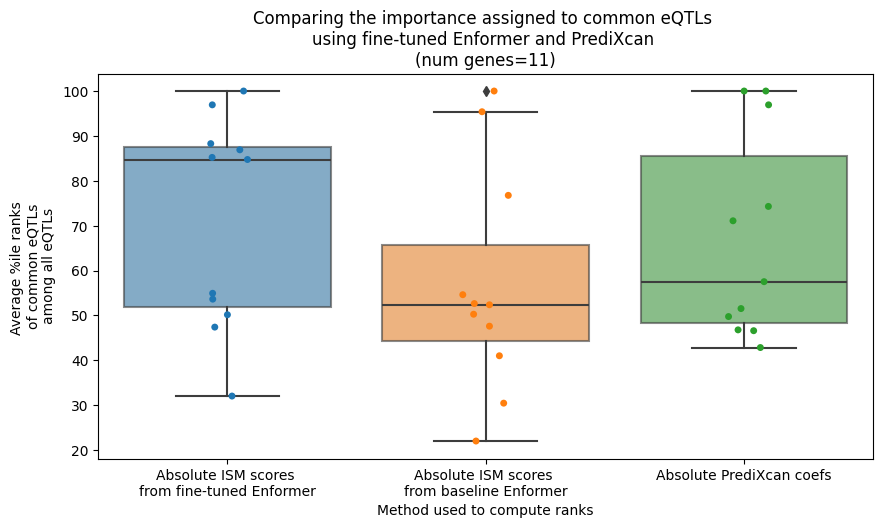

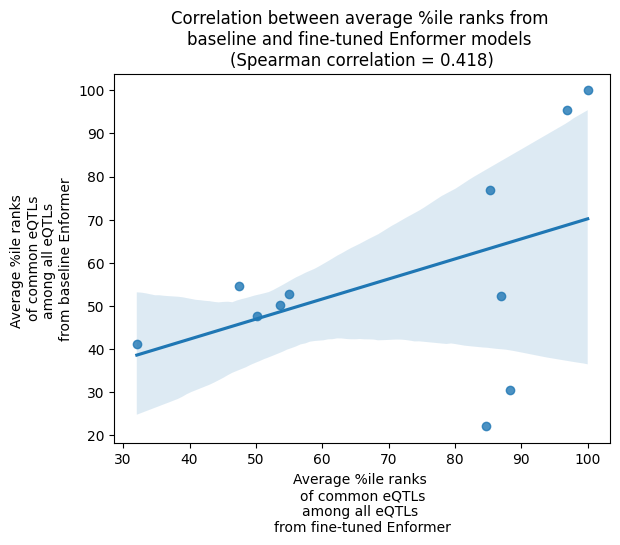

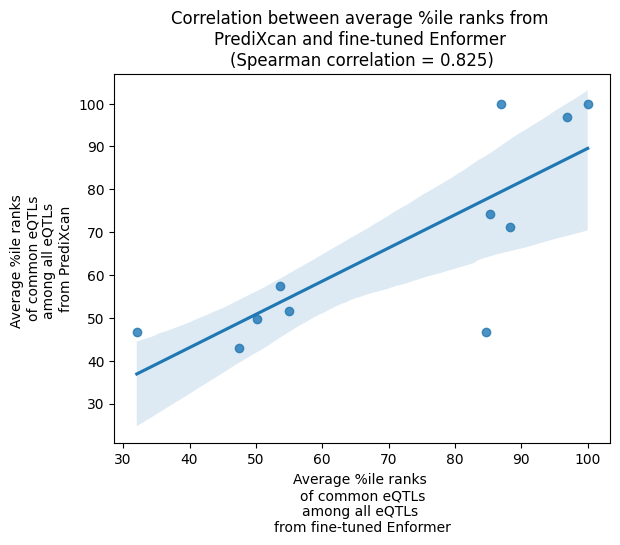

In [10]:
gene_stats = {}
gene_stats["gene"] = []
gene_stats["avg_rank_of_common_eQTLs"] = []
gene_stats["method"] = []

for gene in tqdm(all_eQTLs["our_gene_name"].unique()):
    all_eQTLs_from_gene = all_eQTLs[all_eQTLs["our_gene_name"] == gene].reset_index(
        drop=True
    )
    if all_eQTLs_from_gene["is_common_eQTL"].sum() > 0:
        print(
            gene, len(all_eQTLs_from_gene), all_eQTLs_from_gene["is_common_eQTL"].sum()
        )

        assert (
            pd.isna(
                all_eQTLs_from_gene[all_eQTLs_from_gene["is_common_eQTL"]][
                    "abs_coefs_for_eQTLs"
                ]
            ).sum()
            == 0
        )

        # first compute average rank of common eQTLs using fine-tuned Enformer ISM scores
        gene_stats["gene"].append(gene)
        ranks = (
            all_eQTLs_from_gene["abs_ism_scores_for_eQTLs"].rank(pct=True).values * 100
        )
        avg_rank = ranks[all_eQTLs_from_gene["is_common_eQTL"]].mean()
        gene_stats["avg_rank_of_common_eQTLs"].append(avg_rank)
        gene_stats["method"].append("Absolute ISM scores \nfrom fine-tuned Enformer")

        # second compute delta using baseline Enformer ISM scores
        gene_stats["gene"].append(gene)
        ranks = (
            all_eQTLs_from_gene["baseline_abs_ism_scores_for_eQTLs"]
            .rank(pct=True)
            .values
            * 100
        )
        avg_rank = ranks[all_eQTLs_from_gene["is_common_eQTL"]].mean()
        gene_stats["avg_rank_of_common_eQTLs"].append(avg_rank)
        gene_stats["method"].append("Absolute ISM scores \nfrom baseline Enformer")

        # finally compute delta using PrediXcan coefs
        gene_stats["gene"].append(gene)
        ranks = all_eQTLs_from_gene["abs_coefs_for_eQTLs"].rank(pct=True).values * 100
        avg_rank = ranks[all_eQTLs_from_gene["is_common_eQTL"]].mean()
        gene_stats["avg_rank_of_common_eQTLs"].append(avg_rank)
        gene_stats["method"].append("Absolute PrediXcan coefs")

gene_stats = pd.DataFrame(gene_stats)
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(
    data=gene_stats,
    y="avg_rank_of_common_eQTLs",
    x="method",
    boxprops={"alpha": 0.6},
    ax=ax,
)
sns.stripplot(
    data=gene_stats,
    y="avg_rank_of_common_eQTLs",
    x="method",
    ax=ax,
    hue="method",
    legend=None,
)
plt.ylabel("Average %ile ranks \nof common eQTLs\namong all eQTLs")
plt.xlabel("Method used to compute ranks")
plt.title(
    f"Comparing the importance assigned to common eQTLs \nusing fine-tuned Enformer and PrediXcan \n(num genes={len(gene_stats['gene'].unique())})"
)
plt.show()

sns.regplot(
    x=gene_stats[
        gene_stats["method"] == "Absolute ISM scores \nfrom fine-tuned Enformer"
    ]["avg_rank_of_common_eQTLs"].values,
    y=gene_stats[
        gene_stats["method"] == "Absolute ISM scores \nfrom baseline Enformer"
    ]["avg_rank_of_common_eQTLs"].values,
)
spr = spearmanr(
    gene_stats[
        gene_stats["method"] == "Absolute ISM scores \nfrom fine-tuned Enformer"
    ]["avg_rank_of_common_eQTLs"].values,
    gene_stats[gene_stats["method"] == "Absolute ISM scores \nfrom baseline Enformer"][
        "avg_rank_of_common_eQTLs"
    ].values,
)[0]
plt.title(
    f"Correlation between average %ile ranks from \nbaseline and fine-tuned Enformer models \n(Spearman correlation = {spr.round(3)})"
)
plt.xlabel(
    "Average %ile ranks \nof common eQTLs\namong all eQTLs \nfrom fine-tuned Enformer"
)
plt.ylabel(
    "Average %ile ranks \nof common eQTLs\namong all eQTLs \nfrom baseline Enformer"
)
plt.show()

sns.regplot(
    x=gene_stats[
        gene_stats["method"] == "Absolute ISM scores \nfrom fine-tuned Enformer"
    ]["avg_rank_of_common_eQTLs"].values,
    y=gene_stats[gene_stats["method"] == "Absolute PrediXcan coefs"][
        "avg_rank_of_common_eQTLs"
    ].values,
)
spr = spearmanr(
    gene_stats[
        gene_stats["method"] == "Absolute ISM scores \nfrom fine-tuned Enformer"
    ]["avg_rank_of_common_eQTLs"].values,
    gene_stats[gene_stats["method"] == "Absolute PrediXcan coefs"][
        "avg_rank_of_common_eQTLs"
    ].values,
)[0]
plt.title(
    f"Correlation between average %ile ranks from \nPrediXcan and fine-tuned Enformer \n(Spearman correlation = {spr.round(3)})"
)
plt.xlabel(
    "Average %ile ranks \nof common eQTLs\namong all eQTLs \nfrom fine-tuned Enformer"
)
plt.ylabel("Average %ile ranks \nof common eQTLs\namong all eQTLs \nfrom PrediXcan")
plt.show()